# Mercari NLP

In [122]:
#Standard imports
import pandas as pd
import os
import sys
import string
import re
import numpy as np

#Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#SKlearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

#NLTK
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, sent_tokenize
from nltk import WordNetLemmatizer # lemmatizer using WordNet
from nltk.corpus import wordnet # imports WordNet
from nltk import pos_tag # nltk's native part of speech tagging

## Preproccessing

In [5]:
topic_df = pd.read_csv("/Users/javm/Desktop/Mercari-Price-Prediction-Project/topic")

In [6]:
topic_df

,train_id,name,item_condition_id,category_name,price,shipping,item_description,brand_mention_True,compund_sentiment_desc,clothing,beauty products,women's clothing,accessories,electronics
0,1392338,Size small Gianni Bini Dress,2,"Women Dresses Above Knee, Mini",14.0,0,Beautiful dress from Dilliards. Size small. La...,0,0.6988,0.000000,0.000000,0.000000,0.039967,0.000000
1,1125521,36B Victoria's Secret & Aerie Bra Set,3,Women Underwear Bras,41.0,0,Wireless. Good Used Condition. Smoke free home...,1,0.7351,0.000255,0.000000,0.001837,0.034277,0.000000
2,662640,Victoria's Secret Leggings,2,"Women Athletic Apparel Pants, Tights, Leggings",24.0,0,From a smoke free home Size small,1,0.5106,0.089750,0.000000,0.000000,0.000000,0.000000
3,195122,Morphe 35P palette w/FREE GIFTS!!,3,Beauty Makeup Makeup Palettes,19.0,0,"Unused, but one shadow broken. A little bit of...",1,0.9750,0.000000,0.078874,0.000000,0.000000,0.000000
4,1319269,Monster high doll for ashley,3,Kids Toys Dolls & Accessories,11.0,1,Duece,0,0.0000,0.000000,0.000000,0.000000,0.007231,0.034118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,51125,iPhone 7 Plus Otter Box Defender,2,"Electronics Cell Phones & Accessories Cases, C...",26.0,0,Barely used still like new,1,0.3041,0.000000,0.000000,0.000000,0.000000,0.120283
99996,11925,Lularoe Azure XL,3,Women Dresses Knee-Length,16.0,1,Violet azure with white polka dots. Fits like ...,1,0.4753,0.000000,0.000000,0.002292,0.051751,0.000000
99997,875729,7 Bundle Wii + GameCube Games,3,Electronics Video Games & Consoles Games,22.0,1,Total of 7 games - rec room - Mario sports mix...,1,0.7351,0.000000,0.000000,0.000000,0.000000,0.033468
99998,1250401,Huda beauty,1,Beauty Makeup Makeup Palettes,21.0,0,Brand new never used,1,0.0000,0.000000,0.078874,0.000000,0.000000,0.000000


In [7]:
topic_df['category_name'] = topic_df['category_name'].str.replace('/', ' ')

In [8]:
topic_df.isna().sum()

train_id                  0
name                      0
item_condition_id         0
category_name             0
price                     0
shipping                  0
item_description          0
brand_mention_True        0
compund_sentiment_desc    0
clothing                  0
beauty products           0
women's clothing          0
accessories               0
electronics               0
dtype: int64

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from nltk import WordNetLemmatizer # lemmatizer using WordNet
from nltk.corpus import wordnet # imports WordNet
from nltk import pos_tag # nltk's native part of speech tagging

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [11]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        pass
    
    def fit(self, data, y = 0):
        
        return self
    
    def transform(self, data, y = 0):
        fully_normalized_corpus = data.apply(self.process_doc)
        
        return fully_normalized_corpus
        
    def process_doc(self, doc):

        wnl = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None

        doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok not in stop_words)) ]

        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
        doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

        return " ".join(doc_norm)

In [12]:
proc = TextPreprocessor()

In [13]:
df1 = proc.fit_transform(topic_df['item_description'])

In [14]:
df2 = proc.fit_transform(topic_df['category_name'])

In [15]:
df3 = proc.fit_transform(topic_df['name'])

In [16]:
df12 = df1.str.cat(df2, sep = ' ')

In [17]:
df123 = df12.str.cat(df3, sep = ' ')

In [18]:
df123

0        beautiful dress dilliards size small lace deta...
1        wireless good use condition smoke free home vi...
2        smoke free home size small woman athletic appa...
3        unused shadow break little bit dust break shad...
4        duece kid toy doll accessory monster high doll...
                               ...                        
99995    barely use still new electronics cell phone ac...
99996    violet azure white polka dot fit maxi only wor...
99997    total game rec room mario sport mix fifa socce...
99998    brand new never use beauty makeup makeup palet...
99999    authentic brand new contain tag come keychain ...
Name: item_description, Length: 100000, dtype: object

In [19]:
#total_description_df= pd.Series(["df123"],name="total_description")
total_description_df = df123.to_frame()

In [20]:
total_description_df.rename(columns ={'item_description' : 'total_description'}, inplace = True)

In [21]:
total_description_df

,total_description
0,beautiful dress dilliards size small lace deta...
1,wireless good use condition smoke free home vi...
2,smoke free home size small woman athletic appa...
3,unused shadow break little bit dust break shad...
4,duece kid toy doll accessory monster high doll...
...,...
99995,barely use still new electronics cell phone ac...
99996,violet azure white polka dot fit maxi only wor...
99997,total game rec room mario sport mix fifa socce...
99998,brand new never use beauty makeup makeup palet...


In [22]:
total_description_df.to_csv('vec_df',index=False)

In [23]:
vec_df = pd.read_csv('/Users/javm/Desktop/Mercari-Price-Prediction-Project/vec_df')

In [24]:
vec_df

,total_description
0,beautiful dress dilliards size small lace deta...
1,wireless good use condition smoke free home vi...
2,smoke free home size small woman athletic appa...
3,unused shadow break little bit dust break shad...
4,duece kid toy doll accessory monster high doll...
...,...
99995,barely use still new electronics cell phone ac...
99996,violet azure white polka dot fit maxi only wor...
99997,total game rec room mario sport mix fifa socce...
99998,brand new never use beauty makeup makeup palet...


In [25]:
df = pd.concat([topic_df, total_description_df], axis = 1, join = 'inner')
df

,train_id,name,item_condition_id,category_name,price,shipping,item_description,brand_mention_True,compund_sentiment_desc,clothing,beauty products,women's clothing,accessories,electronics,total_description
0,1392338,Size small Gianni Bini Dress,2,"Women Dresses Above Knee, Mini",14.0,0,Beautiful dress from Dilliards. Size small. La...,0,0.6988,0.000000,0.000000,0.000000,0.039967,0.000000,beautiful dress dilliards size small lace deta...
1,1125521,36B Victoria's Secret & Aerie Bra Set,3,Women Underwear Bras,41.0,0,Wireless. Good Used Condition. Smoke free home...,1,0.7351,0.000255,0.000000,0.001837,0.034277,0.000000,wireless good use condition smoke free home vi...
2,662640,Victoria's Secret Leggings,2,"Women Athletic Apparel Pants, Tights, Leggings",24.0,0,From a smoke free home Size small,1,0.5106,0.089750,0.000000,0.000000,0.000000,0.000000,smoke free home size small woman athletic appa...
3,195122,Morphe 35P palette w/FREE GIFTS!!,3,Beauty Makeup Makeup Palettes,19.0,0,"Unused, but one shadow broken. A little bit of...",1,0.9750,0.000000,0.078874,0.000000,0.000000,0.000000,unused shadow break little bit dust break shad...
4,1319269,Monster high doll for ashley,3,Kids Toys Dolls & Accessories,11.0,1,Duece,0,0.0000,0.000000,0.000000,0.000000,0.007231,0.034118,duece kid toy doll accessory monster high doll...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,51125,iPhone 7 Plus Otter Box Defender,2,"Electronics Cell Phones & Accessories Cases, C...",26.0,0,Barely used still like new,1,0.3041,0.000000,0.000000,0.000000,0.000000,0.120283,barely use still new electronics cell phone ac...
99996,11925,Lularoe Azure XL,3,Women Dresses Knee-Length,16.0,1,Violet azure with white polka dots. Fits like ...,1,0.4753,0.000000,0.000000,0.002292,0.051751,0.000000,violet azure white polka dot fit maxi only wor...
99997,875729,7 Bundle Wii + GameCube Games,3,Electronics Video Games & Consoles Games,22.0,1,Total of 7 games - rec room - Mario sports mix...,1,0.7351,0.000000,0.000000,0.000000,0.000000,0.033468,total game rec room mario sport mix fifa socce...
99998,1250401,Huda beauty,1,Beauty Makeup Makeup Palettes,21.0,0,Brand new never used,1,0.0000,0.000000,0.078874,0.000000,0.000000,0.000000,brand new never use beauty makeup makeup palet...


In [26]:
ready_df = df.drop(['name', 'category_name', 'item_description'], axis=1)

ready_df

,train_id,item_condition_id,price,shipping,brand_mention_True,compund_sentiment_desc,clothing,beauty products,women's clothing,accessories,electronics,total_description
0,1392338,2,14.0,0,0,0.6988,0.000000,0.000000,0.000000,0.039967,0.000000,beautiful dress dilliards size small lace deta...
1,1125521,3,41.0,0,1,0.7351,0.000255,0.000000,0.001837,0.034277,0.000000,wireless good use condition smoke free home vi...
2,662640,2,24.0,0,1,0.5106,0.089750,0.000000,0.000000,0.000000,0.000000,smoke free home size small woman athletic appa...
3,195122,3,19.0,0,1,0.9750,0.000000,0.078874,0.000000,0.000000,0.000000,unused shadow break little bit dust break shad...
4,1319269,3,11.0,1,0,0.0000,0.000000,0.000000,0.000000,0.007231,0.034118,duece kid toy doll accessory monster high doll...
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,51125,2,26.0,0,1,0.3041,0.000000,0.000000,0.000000,0.000000,0.120283,barely use still new electronics cell phone ac...
99996,11925,3,16.0,1,1,0.4753,0.000000,0.000000,0.002292,0.051751,0.000000,violet azure white polka dot fit maxi only wor...
99997,875729,3,22.0,1,1,0.7351,0.000000,0.000000,0.000000,0.000000,0.033468,total game rec room mario sport mix fifa socce...
99998,1250401,1,21.0,0,1,0.0000,0.000000,0.078874,0.000000,0.000000,0.000000,brand new never use beauty makeup makeup palet...


In [27]:
prc_steps = [('tfid', TfidfVectorizer(max_features = 2000))]
tfid_pipeline = Pipeline(prc_steps)

In [28]:
processed_text = tfid_pipeline.fit_transform(df['total_description'])

In [29]:
processed_text

<100000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 1704835 stored elements in Compressed Sparse Row format>

In [30]:
# feat_names = tfid_pipeline['tfid'].get_feature_names()

word_vec = pd.DataFrame(processed_text.toarray())


In [31]:
word_vec

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212203,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.193565,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
ready_df

,train_id,item_condition_id,price,shipping,brand_mention_True,compund_sentiment_desc,clothing,beauty products,women's clothing,accessories,electronics,total_description
0,1392338,2,14.0,0,0,0.6988,0.000000,0.000000,0.000000,0.039967,0.000000,beautiful dress dilliards size small lace deta...
1,1125521,3,41.0,0,1,0.7351,0.000255,0.000000,0.001837,0.034277,0.000000,wireless good use condition smoke free home vi...
2,662640,2,24.0,0,1,0.5106,0.089750,0.000000,0.000000,0.000000,0.000000,smoke free home size small woman athletic appa...
3,195122,3,19.0,0,1,0.9750,0.000000,0.078874,0.000000,0.000000,0.000000,unused shadow break little bit dust break shad...
4,1319269,3,11.0,1,0,0.0000,0.000000,0.000000,0.000000,0.007231,0.034118,duece kid toy doll accessory monster high doll...
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,51125,2,26.0,0,1,0.3041,0.000000,0.000000,0.000000,0.000000,0.120283,barely use still new electronics cell phone ac...
99996,11925,3,16.0,1,1,0.4753,0.000000,0.000000,0.002292,0.051751,0.000000,violet azure white polka dot fit maxi only wor...
99997,875729,3,22.0,1,1,0.7351,0.000000,0.000000,0.000000,0.000000,0.033468,total game rec room mario sport mix fifa socce...
99998,1250401,1,21.0,0,1,0.0000,0.000000,0.078874,0.000000,0.000000,0.000000,brand new never use beauty makeup makeup palet...


In [33]:
forest_df = pd.concat([ready_df, word_vec], axis =1,join='inner')

In [34]:
forest_df.drop(['total_description'], axis = 1,inplace = True)

In [35]:
forest_df.to_csv('sample_before_train_test', index = False)

In [94]:
forest_df.set_index('train_id', inplace = True)

In [95]:
forest_df

,item_condition_id,price,shipping,brand_mention_True,compund_sentiment_desc,clothing,beauty products,women's clothing,accessories,electronics,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
train_id,,,,,,,,,,,,,,,,,,,,,
1392338,2,14.0,0,0,0.6988,0.000000,0.000000,0.000000,0.039967,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1125521,3,41.0,0,1,0.7351,0.000255,0.000000,0.001837,0.034277,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
662640,2,24.0,0,1,0.5106,0.089750,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195122,3,19.0,0,1,0.9750,0.000000,0.078874,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1319269,3,11.0,1,0,0.0000,0.000000,0.000000,0.000000,0.007231,0.034118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51125,2,26.0,0,1,0.3041,0.000000,0.000000,0.000000,0.000000,0.120283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11925,3,16.0,1,1,0.4753,0.000000,0.000000,0.002292,0.051751,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
875729,3,22.0,1,1,0.7351,0.000000,0.000000,0.000000,0.000000,0.033468,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
forest_df['item_condition_id'].value_counts()

1    44114
3    28426
2    25165
4     2146
5      149
Name: item_condition_id, dtype: int64

In [96]:
from sklearn.model_selection import train_test_split

y = forest_df['price']
X = forest_df.drop(columns = ['price'])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

## Gridsearch

In [113]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [10,20,40]}  
rfr = RandomForestRegressor(max_features= 'sqrt',n_estimators=50)

grid = GridSearchCV(rfr, param_grid, refit = True, verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid.fit(X_train, y_train) 
 
# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(X_test) 
   
# print classification report 
print(classification_report(y_test, grid_predictions))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


## HistGradientBoosting

In [177]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [197]:
hist_params = {"model__learning_rate" : [0.1, 0.15, 0.2, 0.25],
               "model__max_iter": [215, 220, 225, 230, 245],
               "model__min_samples_leaf": [1, 3, 5],
               "model__max_leaf_nodes" : [29, 31, 33, 35],
               "model__max_depth" : [17, 19, 21, 23, 25]}

In [198]:
hist = HistGradientBoostingRegressor(hist_params, random_state = 42, verbose = 2)

In [199]:
hist.fit(X_train,y_train)

ValueError: Loss {'model__learning_rate': [0.1, 0.15, 0.2, 0.25], 'model__max_iter': [215, 220, 225, 230, 245], 'model__min_samples_leaf': [1, 3, 5], 'model__max_leaf_nodes': [29, 31, 33, 35], 'model__max_depth': [17, 19, 21, 23, 25]} is not supported for HistGradientBoostingRegressor. Accepted losses: least_squares, least_absolute_deviation, poisson.

In [120]:
y_predict = hist.predict(X_test)

In [124]:
hist.score(X_train,y_train)

0.5228122613517541

In [125]:
hist.score(X_test,y_test)

0.31825314275392236

## Random Forest

In [97]:
from sklearn.ensemble import RandomForestRegressor

In [98]:
rf = RandomForestRegressor(random_state = 42)

In [99]:
rf.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [100]:
rf.score(X_train,y_train)

0.907013293119612

In [101]:
rf.score(X_test,y_test)

0.2732062525883895

In [102]:
y_pred = rf.predict(X_test)

In [44]:
from sklearn.metrics import classification_report

In [45]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [103]:
rf.feature_importances_

array([1.87092517e-02, 6.97217030e-03, 1.57474487e-02, ...,
       1.89602219e-04, 5.77646898e-05, 1.24683022e-04])

In [65]:
#rf.feature_importances_

array([1.28407647e-02, 1.80885926e-02, 6.73640022e-03, ...,
       1.66882211e-04, 1.93655455e-05, 1.08684856e-04])

In [ ]:
# plt.plot(aapl['Close'].to_numpy(), label='Close')

TypeError: 'value' must be an instance of str or bytes, not a int

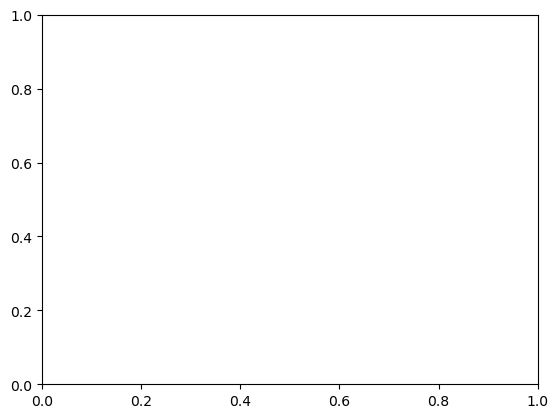

In [74]:
plt.barh(feature_names, rf.feature_importances_)

## Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression

In [48]:
lr = LogisticRegression(random_state = 42)

In [49]:
lr.fit(X_train, y_train)

ValueError: Unknown label type: 'continuous'

 ## Define Sigmoid

In [ ]:
def sigmoid(z):
    s = 1/1(1+np.exp(-z))
    
    return s

def initialize_with_zeros(dim):
    w = np.zeros(shape=(dim, 1))
    b = 0
    
    assert(s.shape == (dim, 1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

In [ ]:
X_train.shape

In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

In [ ]:
# Original OG CNN
model = Sequential()
model.add(Input(shape= (number of dimensions in data)))
model.add(Dense(128, activation=‘relu’))
model_reg.add(Dropout(0.2))
model.add(Dense(128, activation=‘relu’))
model.add(Dense(64, activation=‘relu’))
model_reg.add(Dropout(0.2))
model.add(Dense(32, activation=‘relu’))
model.add(Dense(1, activation=‘sigmoid’))
model.compile(loss=‘binary_crossentropy’,
              optimizer=‘adam’, metrics=‘accuracy’)
model.summary()


In [ ]:
#Feature of CNN if not enough information by 'patience' epocs, shut it down
trainCallback = EarlyStopping(monitor=‘loss’, min_delta = 1e-6, patience = 20)

In [ ]:
# Fit into CNN   
base = model.fit(X_train,  y_train, epochs = 50, 
                 batch_size = 128, validation_size=0.2 , callbacks=[trainCallback], verbose =1)

In [ ]:
#Graphing   
sns.set()
acc = base.history[‘accuracy’]
val = base.history[‘val_accuracy’]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, ‘-’, label=‘Training accuracy’)
plt.plot(epochs, val, ‘:’, label=‘Validation accuracy’)
plt.title(‘Training and Validation Accuracy’)
plt.xlabel(‘Epoch’)
plt.ylabel(‘Accuracy’)
plt.legend(loc=‘lower right’)
plt.plot()

In [ ]:
#this is optimized for a binary classifier and is a cnn, to do a baseline i would just have one hidden layer:
#more simpler model:
model = Sequential()
model.add(Input(shape= (number of dimensions in data)))
model.add(Dense(128, activation=‘relu’))
model.add(Dense(1, activation=‘sigmoid’))
model.compile(loss=‘binary_crossentropy’,
              optimizer=‘adam’, metrics=‘accuracy’)
model.summary()